## The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

This chellenge requires building a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (i.e. name, age, gender, socio-economic class, etc).

## Data Dictionary

| Variable | Definition	| Key |
| :-- | :-: | :-: |
| survival	| Survival	| 0 = No, 1 = Yes |
| pclass	| Ticket class	| 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex	| Sex |
| Age |	Age in years |
| sibsp	| # of siblings / spouses aboard the Titanic |	
|parch	| # of parents / children aboard the Titanic |	
| ticket	| Ticket number	|
| fare	| Passenger fare |
| cabin	| Cabin number |
| embarked	| Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton |

__Variable Notes:__

__Pclass:__ A proxy for socio-economic status (SES)

1st = Upper, 
2nd = Middle, 
3rd = Lower

__age:__ Age is fractional if less than 1. If the age is estimated, it is in the form 'xx.5'

__sibsp:__ The dataset defines family relations as follows:

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

__parch:__ The dataset defines family relations as follows:

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch = 0 for them.

## Exploratory data analysis

In [1]:
# Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
# Import data into a data frame

df = pd.read_csv('titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Explore the data frame some more

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Find the number of missing values in each column

df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Columns 'Age', 'Cabin', and 'Embarked' have missing values. Since 'Embarked' column has only two missing entries, those rows can be dropped without significantly affecting further analysis. 'PassengerId' column can also be dropped as the data frame provides an index for each passenger.

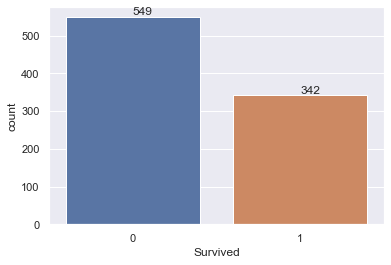

In [5]:
# Let's check how many passengers from this dataset survived

x = df.Survived.value_counts().index
y = df.Survived.value_counts().values

sns.countplot(x='Survived', data=df)

for i in x:
    plt.text(x=x[i], y=y[i]*1.01, s = y[i])

plt.show();

Out of 891 passengers under consideration, only 342 survived.

In [6]:
# Rearrange data frame columns so that the target feature 'Survived' is the right-most column

df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
cols = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

df = df[cols]

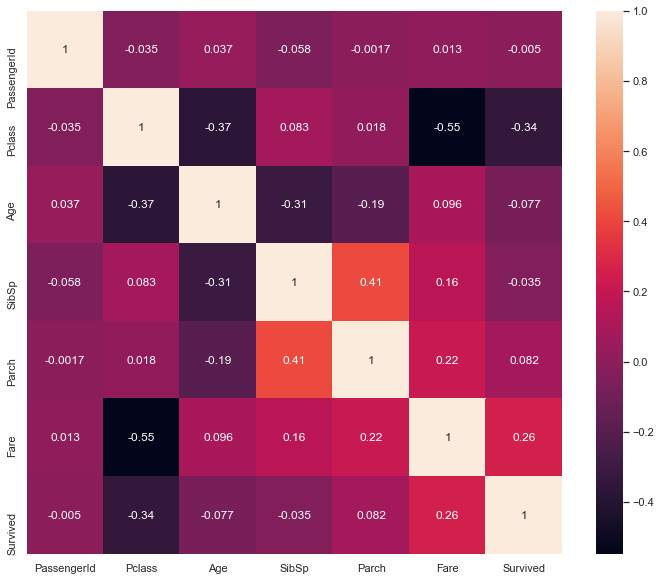

In [8]:
# Let's check relationship between various features and survival status

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)
plt.show();

Two numerical features show significant correlation with the target feature: Pclass (-0.34) and Fare (0.26). In short, a person belonging to a higher class (1st class) paid higher fare for the journey and had improved chance of survival.

Age or having a family member on board (SibSp and Parch) did not have a significant impact on a passenger's survival chance.

There are a few other interesting relationships suggested in the heatmap:

1.'Age' is negatively correlated with 'Pclass', 'SibSp', and 'Parch'. This means a younger person was more likely to be part of the lower class (2nd or 3rd). 

2.A person with higher age was likely to have traveled with less companions. This observation makes sense as usually children and young adults would have been accompanied by one or more family members.

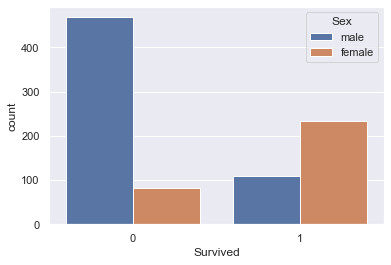

In [9]:
# Let's check if a passenger's sex affected their survival chances

plt.figure()
sns.countplot(x='Survived', data=df, hue='Sex')
plt.show();

A large majority of males did not survive, whereas a significant majority of women did survive. A passenger's sex has a significant impact on their survival.

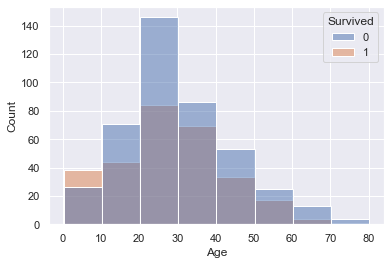

In [10]:
# Let's check how age affects passenger survival

sns.histplot(x='Age', data=df, hue='Survived', bins=8)
plt.show();

Children under the age of 10 had the maximum chance of survival. For all other age groups, mortality rate was higher than survival rate. The survival chances were negliglble for passengers older than 70 years.

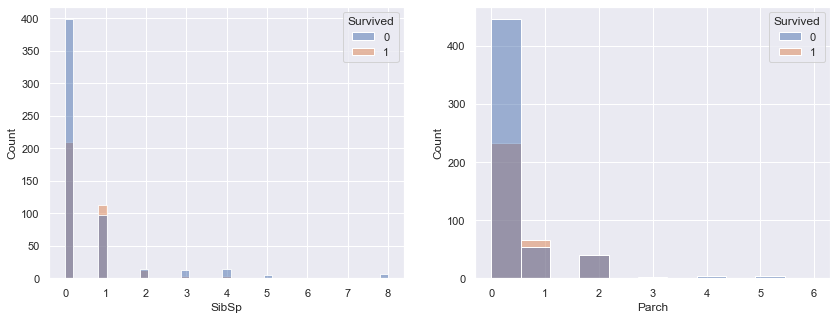

In [11]:
# Check how having a sibling or spouse pn board affects passenger survival

fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.histplot(ax=ax[0], x='SibSp', data=df, hue='Survived')
sns.histplot(ax=ax[1], x='Parch', data=df, hue='Survived')
plt.show();

A large majority of passengers were traveling without a family companion. Those who traveled with one or two companions, had a better chance of survival. This observation makes sense as females were more likely to be the additional passenger from the same family and had a better survival rate.

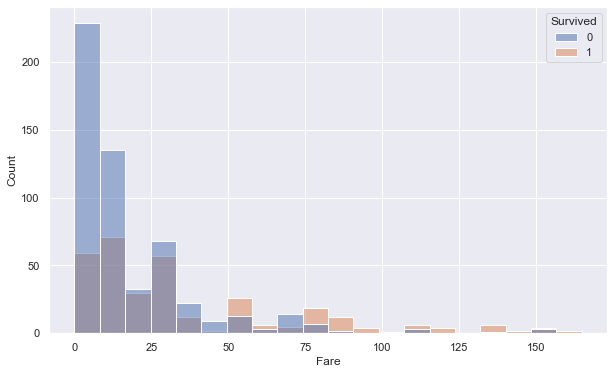

In [12]:
# Check how fare affects passenger survival

plt.figure(figsize=(10,6))
sns.histplot(x='Fare', data=df[df.Fare < 200], hue='Survived', bins=20)
plt.show();

As observed from the correlation heatmap, the passengers who paid higher fare had a better survival rate.

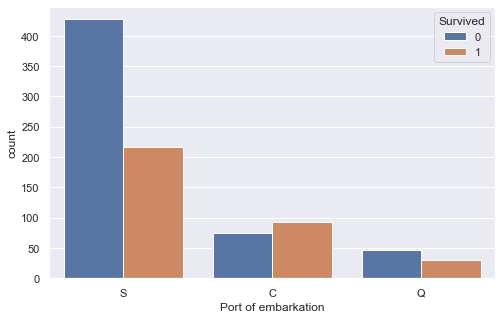

In [13]:
# Check how port of embarkation affects passenger survival

plt.figure(figsize=(8,5))
sns.countplot(x='Embarked', data=df, hue='Survived')
plt.xlabel('Port of embarkation')
plt.show();

Passenger who boarded the ship from Cherbourg (C) had a better survival rate compared to those who embarked their journey from Queenstown (Q) and Southampton (S).

In [14]:
# Explore 'Name' column

df.Name.value_counts()[:5]

Colley, Mr. Edward Pomeroy                       1
Kink, Mr. Vincenz                                1
Arnold-Franchi, Mrs. Josef (Josefine Franchi)    1
O'Driscoll, Miss. Bridget                        1
McCoy, Miss. Agnes                               1
Name: Name, dtype: int64

Looks like one ticket was assigned to each passenger, i.e. there are 891 passengers listed in the data set.

In [15]:
# Explore 'Ticket' column

df.Ticket.value_counts()[:10]

1601            7
CA. 2343        7
347082          7
3101295         6
347088          6
CA 2144         6
S.O.C. 14879    5
382652          5
PC 17757        4
349909          4
Name: Ticket, dtype: int64

Ticket 'CA. 2343' was issued to 7 passengers. Let's explore their details.

In [16]:
df[df.Ticket == 'CA. 2343']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
159,160,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
180,181,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,0
201,202,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
324,325,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
792,793,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,0
846,847,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
863,864,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,0


This ticket was issued to a family none of whom survived. Let's check another ticket to confirm whether families were issued a single ticket.

In [17]:
df[df.Ticket == '349909']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,NaN,S,0
24,25,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.075,NaN,S,0
374,375,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.075,NaN,S,0
567,568,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S,0


Families were indeed issued a single ticket.

In [18]:
# Let's explore 'Cabin' column

df.Cabin.value_counts()[:10]

C23 C25 C27    4
G6             4
B96 B98        4
C22 C26        3
F2             3
E101           3
F33            3
D              3
E24            2
E33            2
Name: Cabin, dtype: int64

A single cabin was assigned to multiple passengers in many cases. Let's explore a few of them.

In [19]:
df[df.Cabin == 'G6']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
10,11,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,1
205,206,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S,0
251,252,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S,0
394,395,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S,1


In [20]:
df[df.Cabin == 'B28']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1


In [21]:
df[df.Cabin == 'D']

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
292,293,2,"Levy, Mr. Rene Jacques",male,36.0,0,0,SC/Paris 2163,12.8750,D,C,0
327,328,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,S,1
473,474,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,D,C,1


Looks like cabins were assigned according to 'Pclass', but not necessarily by sex or port of embarkation.

In [22]:
df.groupby(by = 'Pclass').count()

,PassengerId,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
Pclass,,,,,,,,,,,
1,216,216,216,186,216,216,216,216,176,214,216
2,184,184,184,173,184,184,184,184,16,184,184
3,491,491,491,355,491,491,491,491,12,491,491


Out of 216 passengers who paid for 1st class fare were assigned a cabin. On the other hand, only 16 passengers from 2nd class and 12 passengers from 3rd class were assigned a cabin.

__Further investigation:__

1.Some features that are not yet thoroughly investigated. For example, 'Name' column consists of names of individuals. How can we extract useful information from this column?

2.'Age' column has more than 150 missing values. How can we use this feature for further analysis?

3.'Cabin' columns also has more than 600 missing values. Should we replace the missing values or just drop the entire column?

4.'Ticket' column consists of alpha-numeric entries. While there are no missing values, how can we extract useful information from this column?

5.The heatmap shows weak correlation between the target variable 'Survived' and other features. How accurately can we determine the survival status of RMS-Titanic's passengers?